# Regression Plots

This tutorial is based on [statmodels documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html#Partial-Regression-Plots-(Crime-Data))

In [1]:
import numpy as np

from statsmodels.compat import lzip
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)

## Import data

In this application we use data about the prestige of canadian occupations to estimate a regression model with `prestige` as the response and `income` and `education` as predictors.

 *Note that the observations are occupations. Review this [site](https://vincentarelbundock.github.io/Rdatasets/doc/carData/Prestige.html) to learn more about the data.*

In [3]:
prestige = sm.datasets.get_rdataset("Duncan", "carData", cache=True).data

Note that we can use the utility function `sm.datasets.get_rdataset` to load any R dataset available from the great <a href="https://vincentarelbundock.github.io/Rdatasets/">Rdatasets package</a>. 

In [4]:
prestige.head()

,type,income,education,prestige
accountant,prof,62,86,82
pilot,prof,72,76,83
architect,prof,75,92,90
author,prof,55,90,76
chemist,prof,64,86,90


## Model

In [6]:
# Estimate the model
prestige_model = ols("prestige ~ income + education", data=prestige).fit()

In [7]:
# print regression results
print(prestige_model.summary())

                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     101.2
Date:                Thu, 11 Nov 2021   Prob (F-statistic):           8.65e-17
Time:                        12:04:29   Log-Likelihood:                -178.98
No. Observations:                  45   AIC:                             364.0
Df Residuals:                      42   BIC:                             369.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.0647      4.272     -1.420      0.1

## Diagnostics

### Influence plots

Influence plots show the externally studentized residuals vs. the leverage of each observation. 

- Externally studentized residuals are residuals that are scaled by their standard deviation.
- Leverage is a measure of how far away the independent variable values of an observation are from those of the other observations. High-leverage points are outliers with respect to the independent variables. 

The influence of each point can be visualized by the criterion keyword argument. Options are Cook's distance and DFFITS, two measures of influence. 

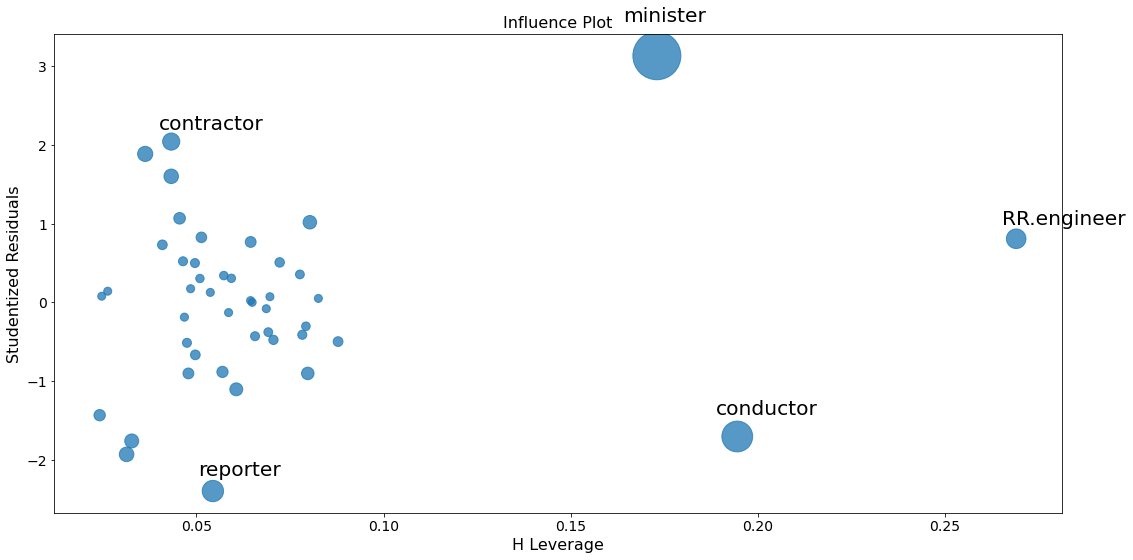

In [8]:
fig = sm.graphics.influence_plot(prestige_model, criterion="cooks")
fig.tight_layout(pad=1.0)

We look for observations with high leverage (X-axis) which additionally show high or low studentized residuals (Y-axis).

There are a few worrisome observations:

- Both contractor and reporter have low leverage but a large residual. 
- RR.engineer has large leverage but small residual. 
- Conductor and minister have both high leverage and large residuals, and, 
therefore, large influence.

### Partial Regression Plots (Duncan)

Since we are doing multivariate regressions, we cannot just look at individual bivariate plots to discern relationships. 
Instead, we want to look at the relationship of the dependent variable and independent variables conditional on the other 
independent variables. We can do this through using partial regression plots, otherwise known as added variable plots. 

In a partial regression plot, to discern the relationship between the response variable and the $k$-th variable, we compute 
the residuals by regressing the response variable versus the independent variables excluding $X_k$. We can denote this by 
$X_{\sim k}$. We then compute the residuals by regressing $X_k$ on $X_{\sim k}$. The partial regression plot is the plot 
of the former versus the latter residuals. 

The notable points of this plot are that the fitted line has slope $\beta_k$ and intercept zero. The residuals of this plot 
are the same as those of the least squares fit of the original model with full $X$. You can discern the effects of the 
individual data values on the estimation of a coefficient easily. If obs_labels is True, then these points are annotated 
with their observation label. You can also see the violation of underlying assumptions such as homoskedasticity and 
linearity.

eval_env: 1


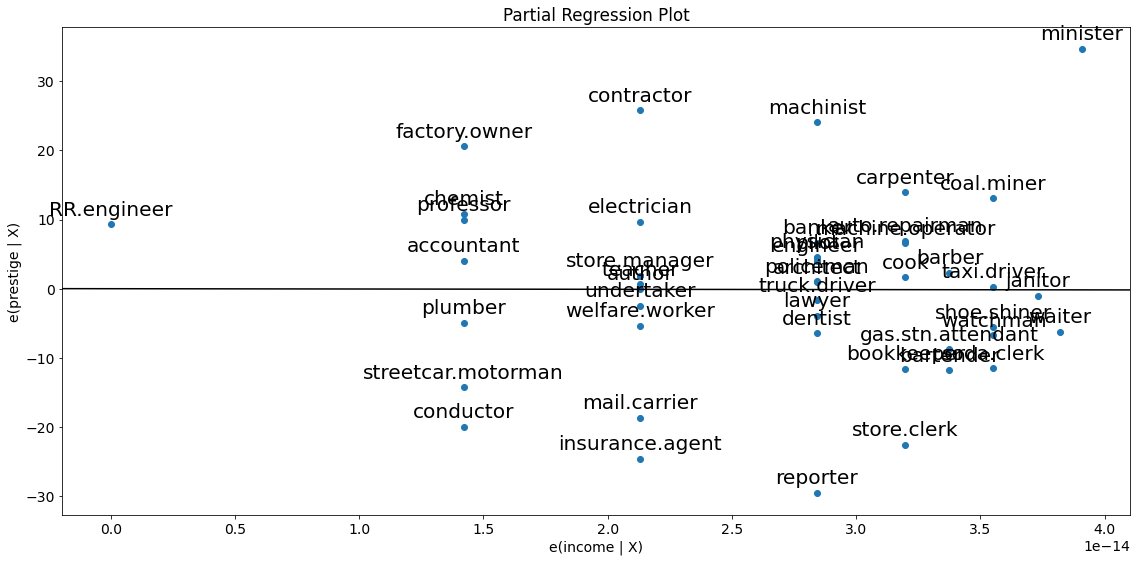

In [8]:
fig = sm.graphics.plot_partregress(
    "prestige", "income", ["income", "education"], data=prestige
)
fig.tight_layout(pad=1.0)

eval_env: 1


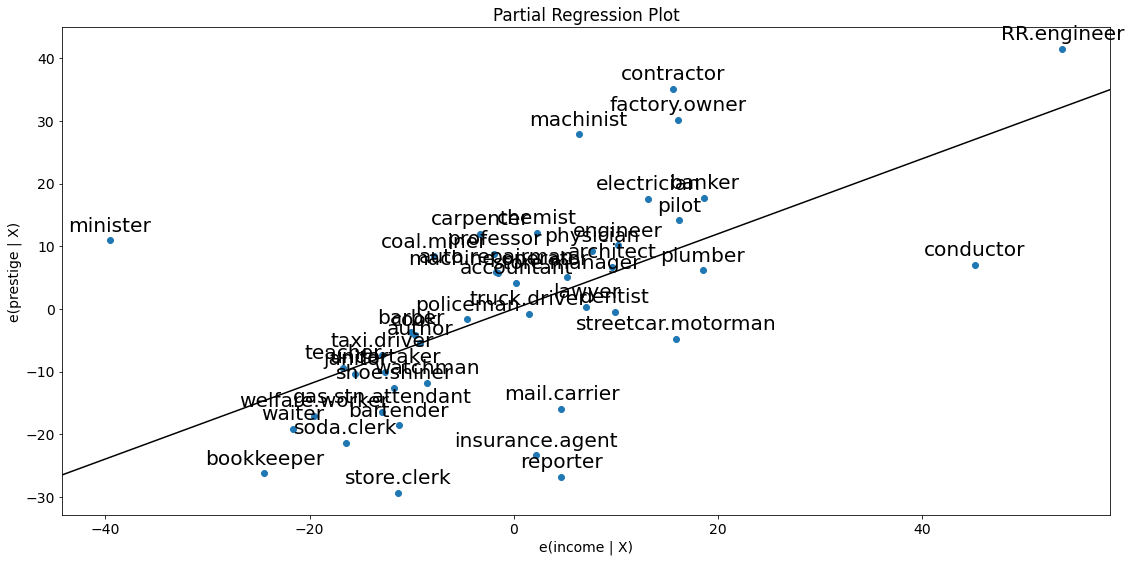

In [9]:
fig = sm.graphics.plot_partregress("prestige", "income", ["education"], data=prestige)
fig.tight_layout(pad=1.0)

As you can see the partial regression plot confirms the influence of conductor, minister, and RR.engineer on the partial relationship between income and prestige. The cases greatly decrease the effect of income on prestige. Dropping these cases confirms this.

In [10]:
subset = ~prestige.index.isin(["conductor", "RR.engineer", "minister"])
prestige_model2 = ols(
    "prestige ~ income + education", data=prestige, subset=subset
).fit()
print(prestige_model2.summary())

                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     138.1
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           2.02e-18
Time:                        19:26:52   Log-Likelihood:                -160.59
No. Observations:                  42   AIC:                             327.2
Df Residuals:                      39   BIC:                             332.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.3174      3.680     -1.717      0.0

For a quick check of all the regressors, you can use plot_partregress_grid. These plots will not label the 
points, but you can use them to identify problems and then use plot_partregress to get more information.

eval_env: 1
eval_env: 1
eval_env: 1


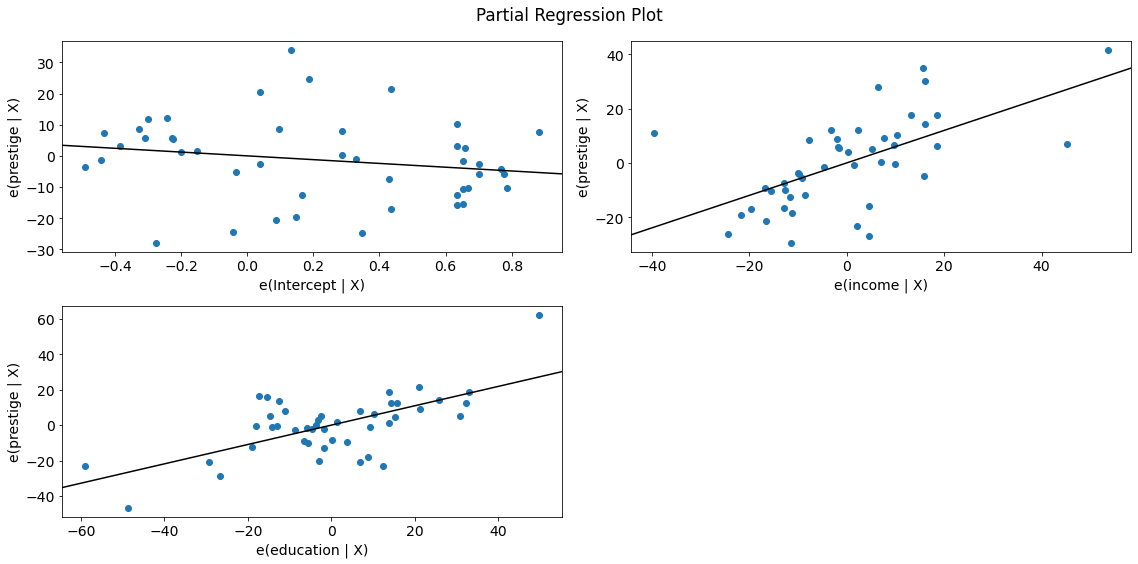

In [11]:
fig = sm.graphics.plot_partregress_grid(prestige_model)
fig.tight_layout(pad=1.0)

### Component-Component plus Residual (CCPR) Plots

The CCPR plot provides a way to judge the effect of one regressor on the 
response variable by taking into account the effects of the other  
independent variables. The partial residuals plot is defined as  
$\text{Residuals} + B_iX_i \text{ }\text{ }$   versus $X_i$. The component adds $B_iX_i$ versus  
$X_i$ to show where the fitted line would lie. Care should be taken if $X_i$  
is highly correlated with any of the other independent variables. If this  
is the case, the variance evident in the plot will be an underestimate of  
the true variance.

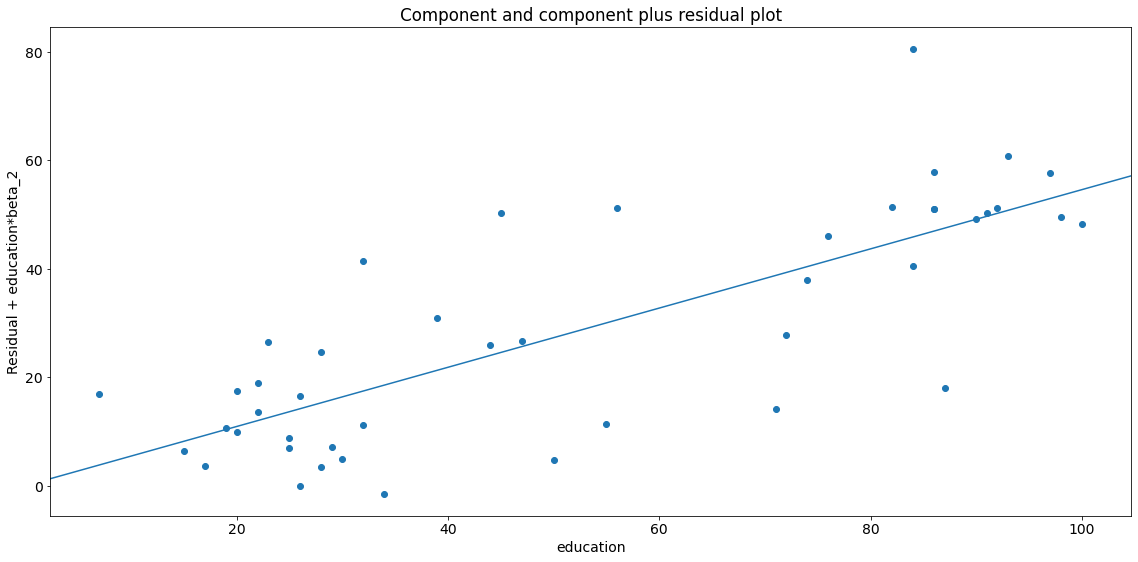

In [12]:
fig = sm.graphics.plot_ccpr(prestige_model, "education")
fig.tight_layout(pad=1.0)

As you can see the relationship between the variation in prestige explained by education conditional on income seems to be linear, though you can see there are some observations that are exerting considerable influence on the relationship. We can quickly look at more than one variable by using plot_ccpr_grid.

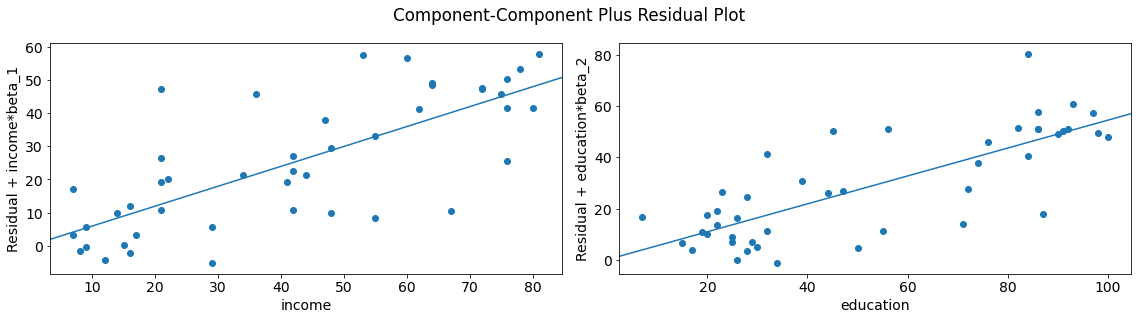

In [13]:
fig = sm.graphics.plot_ccpr_grid(prestige_model)
fig.tight_layout(pad=1.0)

### Single Variable Regression Diagnostics

The plot_regress_exog function is a convenience function that gives a 2x2 plot containing the dependent variable and fitted values with confidence intervals vs. the independent variable chosen, the residuals of the model vs. the chosen independent variable, a partial regression plot, and a CCPR plot. This function can be used for quickly checking modeling assumptions with respect to a single regressor.

eval_env: 1


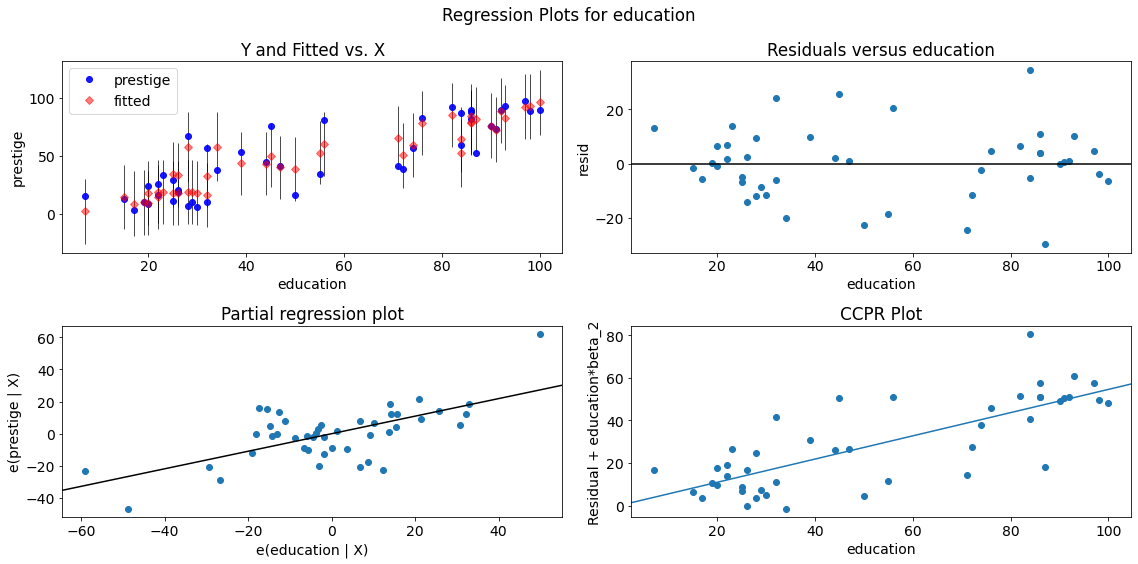

In [14]:
fig = sm.graphics.plot_regress_exog(prestige_model, "education")
fig.tight_layout(pad=1.0)

### Fit Plot

The plot_fit function plots the fitted values versus a chosen independent variable. It includes prediction confidence intervals and optionally plots the true dependent variable.

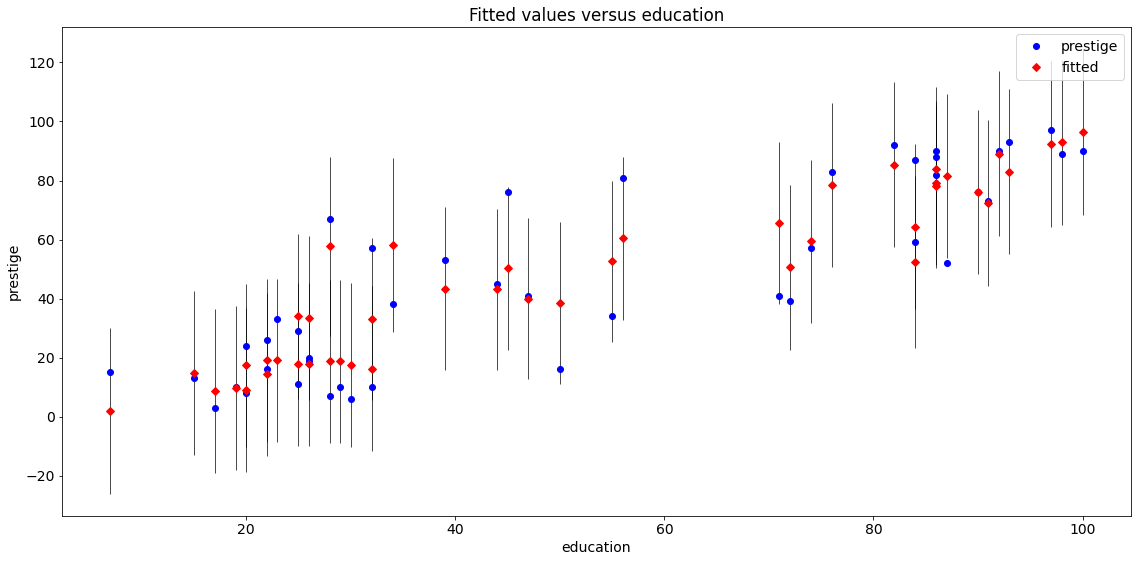

In [15]:
fig = sm.graphics.plot_fit(prestige_model, "education")
fig.tight_layout(pad=1.0)

## Statewide Crime 2009 Dataset

Compare the following to http://www.ats.ucla.edu/stat/stata/webbooks/reg/chapter4/statareg_self_assessment_answers4.htm

Though the data here is not the same as in that example. You could run that example by uncommenting the necessary cells below.

In [16]:
# dta = pd.read_csv("http://www.stat.ufl.edu/~aa/social/csv_files/statewide-crime-2.csv")
# dta = dta.set_index("State", inplace=True).dropna()
# dta.rename(columns={"VR" : "crime",
#                    "MR" : "murder",
#                    "M"  : "pctmetro",
#                    "W"  : "pctwhite",
#                    "H"  : "pcths",
#                    "P"  : "poverty",
#                    "S"  : "single"
#                    }, inplace=True)
#
# crime_model = ols("murder ~ pctmetro + poverty + pcths + single", data=dta).fit()

In [17]:
dta = sm.datasets.statecrime.load_pandas().data

In [18]:
crime_model = ols("murder ~ urban + poverty + hs_grad + single", data=dta).fit()
print(crime_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 murder   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     50.08
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           3.42e-16
Time:                        19:26:54   Log-Likelihood:                -95.050
No. Observations:                  51   AIC:                             200.1
Df Residuals:                      46   BIC:                             209.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -44.1024     12.086     -3.649      0.0

### Partial Regression Plots (Crime Data)

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


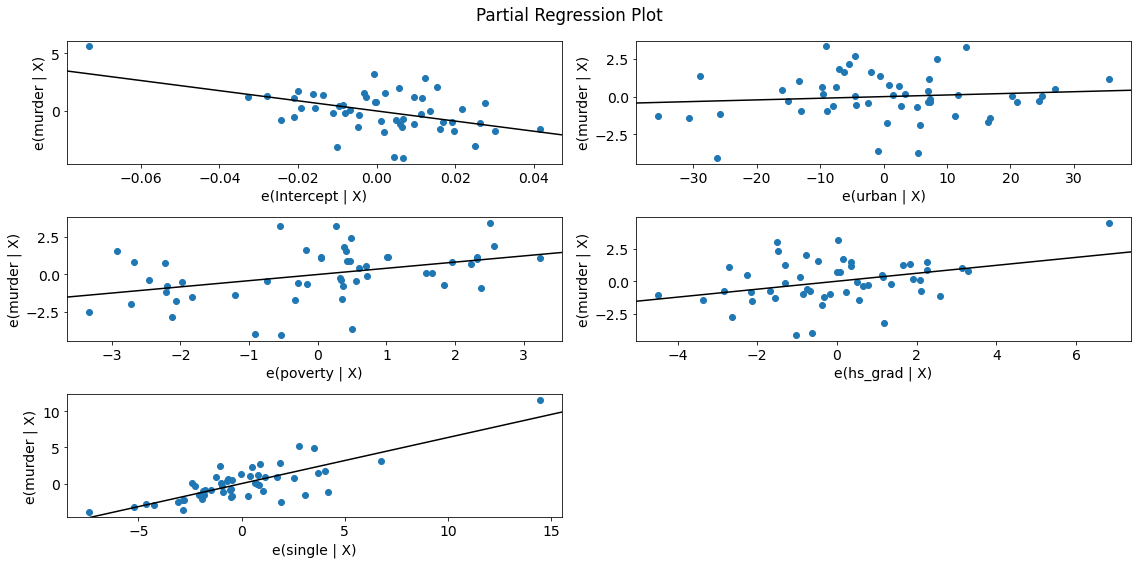

In [19]:
fig = sm.graphics.plot_partregress_grid(crime_model)
fig.tight_layout(pad=1.0)

eval_env: 1


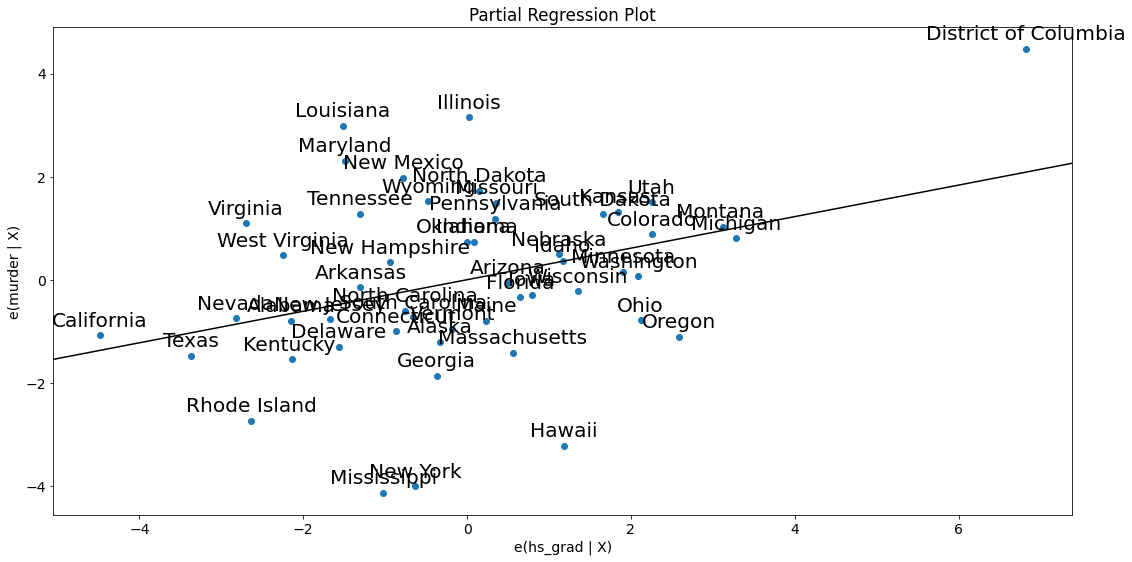

In [20]:
fig = sm.graphics.plot_partregress(
    "murder", "hs_grad", ["urban", "poverty", "single"], data=dta
)
fig.tight_layout(pad=1.0)

### Leverage-Resid<sup>2</sup> Plot

Closely related to the influence_plot is the leverage-resid<sup>2</sup> plot.

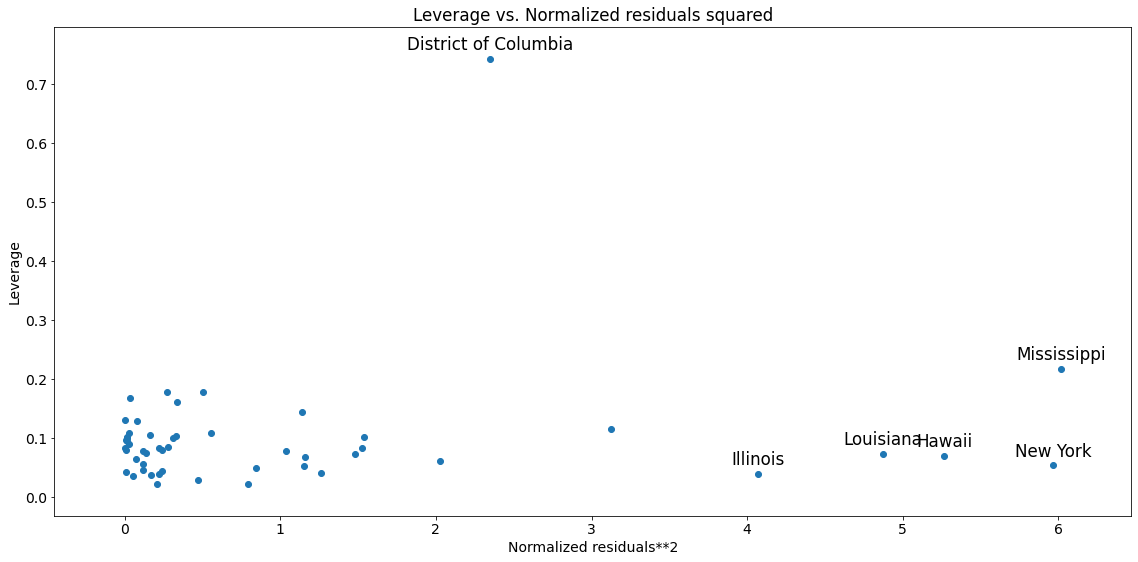

In [21]:
fig = sm.graphics.plot_leverage_resid2(crime_model)
fig.tight_layout(pad=1.0)

### Influence Plot

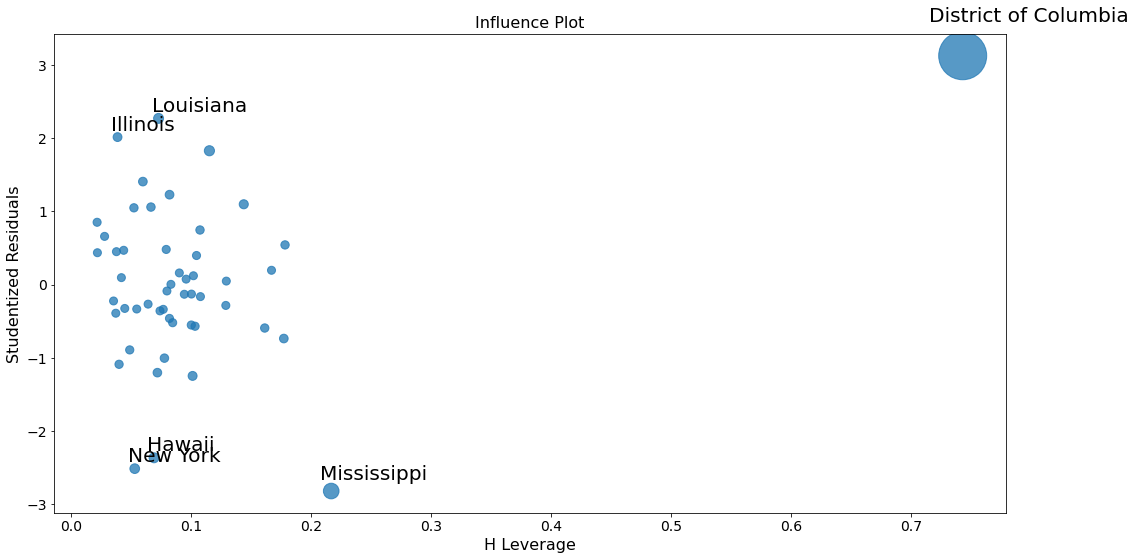

In [22]:
fig = sm.graphics.influence_plot(crime_model)
fig.tight_layout(pad=1.0)

### Using robust regression to correct for outliers.

Part of the problem here in recreating the Stata results is that M-estimators are not robust to leverage points. MM-estimators should do better with this examples.

In [23]:
from statsmodels.formula.api import rlm

In [24]:
rob_crime_model = rlm(
    "murder ~ urban + poverty + hs_grad + single",
    data=dta,
    M=sm.robust.norms.TukeyBiweight(3),
).fit(conv="weights")
print(rob_crime_model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 murder   No. Observations:                   51
Model:                            RLM   Df Residuals:                       46
Method:                          IRLS   Df Model:                            4
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 08 Nov 2021                                         
Time:                        19:26:57                                         
No. Iterations:                    50                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2986      9.494     -0.453      0.6

In [25]:
# rob_crime_model = rlm("murder ~ pctmetro + poverty + pcths + single", data=dta, M=sm.robust.norms.TukeyBiweight()).fit(conv="weights")
# print(rob_crime_model.summary())

There is not yet an influence diagnostics method as part of RLM, but we can recreate them. (This depends on the status of [issue #888](https://github.com/statsmodels/statsmodels/issues/808))

In [26]:
weights = rob_crime_model.weights
idx = weights > 0
X = rob_crime_model.model.exog[idx.values]
ww = weights[idx] / weights[idx].mean()
hat_matrix_diag = ww * (X * np.linalg.pinv(X).T).sum(1)
resid = rob_crime_model.resid
resid2 = resid ** 2
resid2 /= resid2.sum()
nobs = int(idx.sum())
hm = hat_matrix_diag.mean()
rm = resid2.mean()

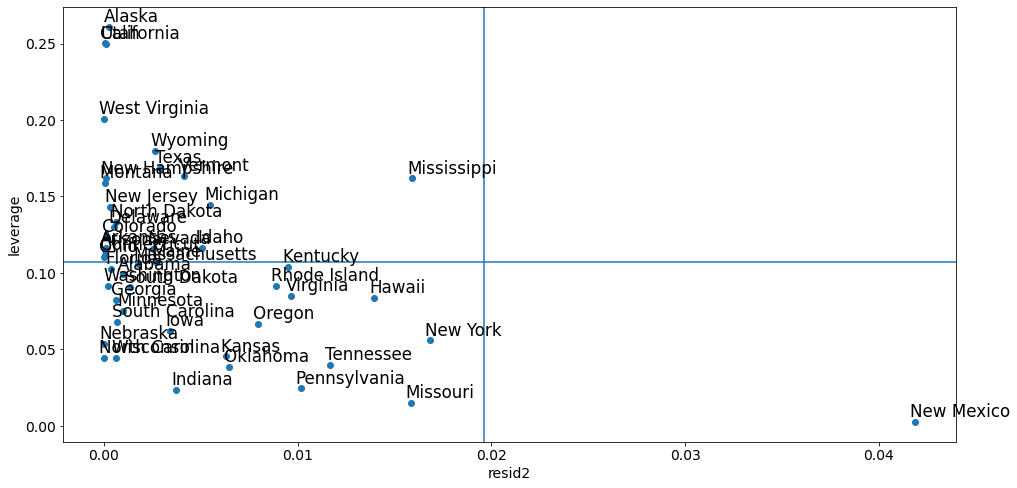

In [27]:
from statsmodels.graphics import utils

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(resid2[idx], hat_matrix_diag, "o")
ax = utils.annotate_axes(
    range(nobs),
    labels=rob_crime_model.model.data.row_labels[idx],
    points=lzip(resid2[idx], hat_matrix_diag),
    offset_points=[(-5, 5)] * nobs,
    size="large",
    ax=ax,
)
ax.set_xlabel("resid2")
ax.set_ylabel("leverage")
ylim = ax.get_ylim()
ax.vlines(rm, *ylim)
xlim = ax.get_xlim()
ax.hlines(hm, *xlim)
ax.margins(0, 0)